In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Garbage_classification.zip

!unzip -qo Garbage_classification.zip

# zip folder is not needed anymore
!rm Garbage_classification.zip

--2023-12-05 12:58:54--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Garbage_classification.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.51, 52.219.66.112, 52.219.160.111, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42074220 (40M) [application/zip]
Saving to: ‘Garbage_classification.zip’

Garbage_classificat 100%[===================>]  40.12M  15.9MB/s    in 2.5s    

2023-12-05 12:58:58 (15.9 MB/s) - ‘Garbage_classification.zip’ saved [42074220/42074220]



In [ ]:
path = 'Garbage classification/'

batch = 32

# The train and test datasets
print("Train dataset")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path+'train', batch_size=batch)

print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(path+'test', batch_size=batch)

Train dataset
Found 1910 files belonging to 5 classes.
Test dataset
Found 480 files belonging to 5 classes.


In [ ]:
# How may samples in each class

for t in ['train', 'test']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
glass  -  400
paper  -  475
metal  -  328
plastic  -  385
cardboard  -  322

 TEST
glass  -  101
paper  -  119
metal  -  82
plastic  -  97
cardboard  -  81


In [ ]:
# Looking into the class labels

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)

Train class names:  ['cardboard', 'glass', 'metal', 'paper', 'plastic']
Test class names:  ['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [ ]:
# Looking into the shape of the batches and individual samples
# Set the input shape

print("Looking into the shape of images and labels in one batch\n")

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (32, 256, 256, 3)
Shape of images labels for one batch:  (32,)


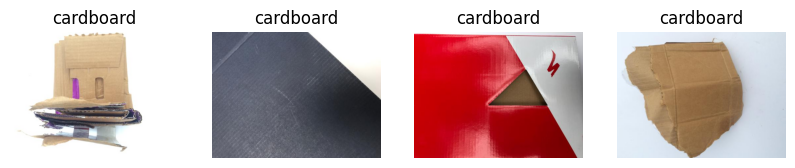

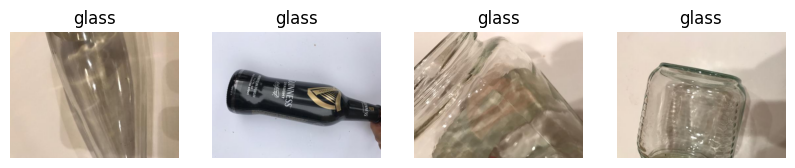

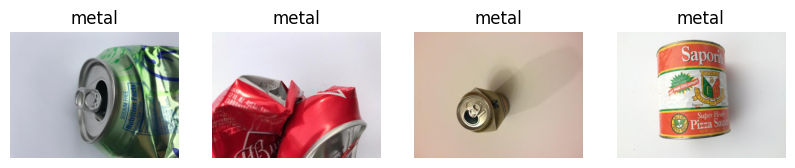

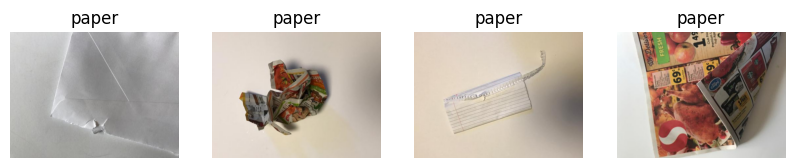

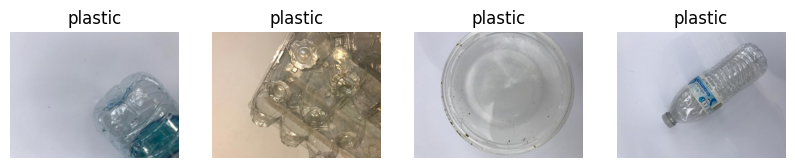

In [ ]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(path + 'train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

In [ ]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
base_model = tensorflow.keras.applications.Xception(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
outputs = tensorflow.keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = tensorflow.keras.Model(inputs, outputs)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.001), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  test_ds, epochs=8)

Epoch 1/8
60/60 [==============================] - 705s 12s/step - loss: 0.8716 - accuracy: 0.7031 - val_loss: 0.6039 - val_accuracy: 0.7937
Epoch 2/8
60/60 [==============================] - 675s 11s/step - loss: 0.4760 - accuracy: 0.8403 - val_loss: 0.5124 - val_accuracy: 0.8375
Epoch 3/8
60/60 [==============================] - 680s 11s/step - loss: 0.3873 - accuracy: 0.8733 - val_loss: 0.4625 - val_accuracy: 0.8521
Epoch 4/8
60/60 [==============================] - 680s 11s/step - loss: 0.3351 - accuracy: 0.8895 - val_loss: 0.4500 - val_accuracy: 0.8479
Epoch 5/8
60/60 [==============================] - 684s 11s/step - loss: 0.2987 - accuracy: 0.9042 - val_loss: 0.4474 - val_accuracy: 0.8458
Epoch 6/8
60/60 [==============================] - 680s 11s/step - loss: 0.2701 - accuracy: 0.9147 - val_loss: 0.4350 - val_accuracy: 0.8562
Epoch 7/8
60/60 [==============================] - 680s 11s/step - loss: 0.2423 - accuracy: 0.9251 - val_loss: 0.4387 - val_accuracy: 0.8625
Epoch 8/8
60/

In [ ]:
model.evaluate(test_ds)
model.summary()

15/15 [==============================] - 135s 9s/step - loss: 0.4342 - accuracy: 0.8646
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 20861480 (79.58 MB)
____________________________________________________________

In [ ]:
def plot(history, variable, variable1):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable1])), history[variable1])
    plt.title(variable)
    plt.legend([variable, variable1])
    plt.title(variable)

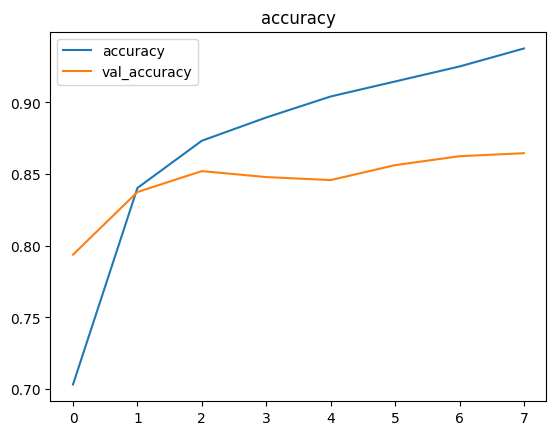

In [ ]:
plot(history.history, "accuracy", "val_accuracy")

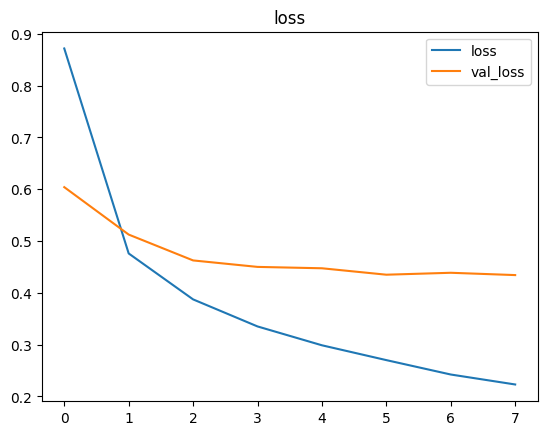

In [ ]:
plot(history.history, "loss", "val_loss")

1/1 [==============================] - 1s 605ms/step
Predicted:  cardboard
True:  cardboard
Probability:  0.9340581


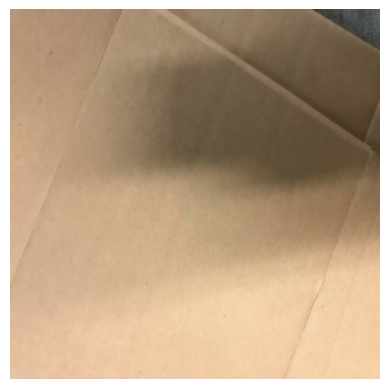

In [ ]:
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0)) # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Predicted: ", class_names[pred])    # Picking the label from class_names based on the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break